# Apple Stock Analysis

### Objective of This Project:

- The primary objective of this project is to analyze historical **Apple stock market data (2012–2019)** and develop reliable time series forecasting models to **predict the next 30 days of closing stock prices**.

#### The project aims to:

- Understand stock price trends, seasonality, and volatility through exploratory data analysis.

- Evaluate and compare **statistical (ARIMA, SARIMA) and machine learning models (Random Forest, XGBoost)** for stock price forecasting.

- Identify the most suitable model based on predictive accuracy and interpretability.

- Deploy the final model using a user-friendly web application that allows users to **select a future date range and visualize both historical and forecasted stock prices**.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ACF and PACF plotting functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model evaluation and tuning
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import pickle

#### LOAD & PREPROCESSING DATA

In [2]:
# Load Apple stock dataset
df = pd.read_csv("Appledataset.csv")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by date to maintain time order
df = df.sort_values('Date')

# Set Date as index for time series analysis
df.set_index('Date', inplace=True)

# Display first five rows
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [3]:
#display last five rows
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500
2019-12-30,289.459991,292.690002,285.220001,291.519989,289.522614,36028600


In [4]:
#checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB


In [5]:
#Statistical Analysis
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,126.707469,127.827594,125.580258,126.741235,119.505548,5.949670e+07
std,50.483753,50.926301,50.124940,50.578369,52.438444,4.683856e+07
min,55.424286,57.085712,55.014286,55.790001,48.921928,1.136200e+07
25%,85.882858,86.717858,85.056427,86.202145,75.056679,2.758565e+07
50%,113.050003,114.190002,111.870003,113.050003,105.222908,4.346900e+07
75%,165.190002,167.409996,163.424995,165.245002,160.047111,7.471030e+07
max,291.119995,293.970001,288.119995,291.519989,289.522614,3.765300e+08


In [6]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
# Handle missing values using forward fill
df.fillna(method='ffill', inplace=True)

In [8]:
#checking duplicates
df.duplicated().sum()

np.int64(0)

#### DAILY RETURNS (IMPORTANT FOR STOCK ANALYSIS)

In [9]:
# Calculate daily percentage returns
# Daily return = (Today price - Yesterday price) / Yesterday price
df['Daily_Return'] = df['Close'].pct_change()

# Remove first row with NaN daily return
df.dropna(inplace=True)


### Exploratory Data Analysis

#### Rolling Statistics (Trend + Volatility) => ROLLING MEAN & ROLLING STANDARD DEVIATION

In [10]:
# Rolling Mean with 10-day window (short-term trend)
df['Rolling_Mean_10'] = df['Close'].rolling(window=10).mean()

# Rolling Mean with 30-day window (medium-term trend)
df['Rolling_Mean_30'] = df['Close'].rolling(window=30).mean()

# Rolling Standard Deviation (30-day volatility)
df['Rolling_Std_30'] = df['Close'].rolling(window=30).std()


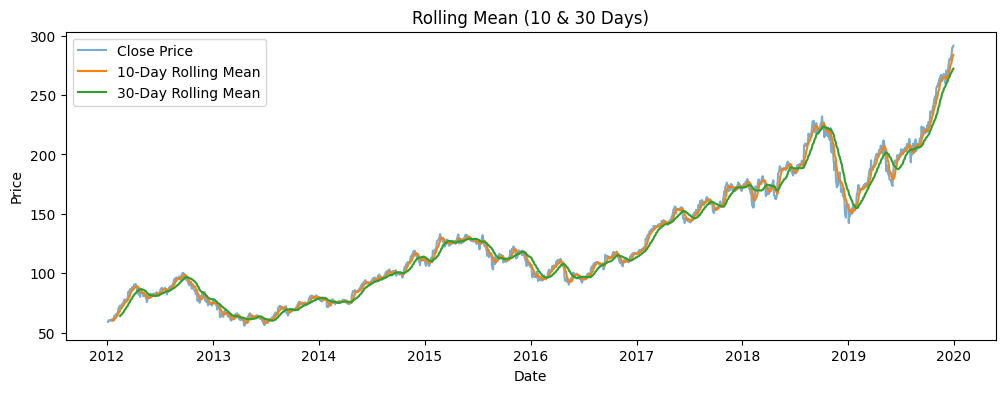

In [11]:
#Plot Rolling Mean (10 & 30)
plt.figure(figsize=(12,4))
plt.plot(df['Close'], label='Close Price', alpha=0.6)
plt.plot(df['Rolling_Mean_10'], label='10-Day Rolling Mean')
plt.plot(df['Rolling_Mean_30'], label='30-Day Rolling Mean')
plt.title("Rolling Mean (10 & 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

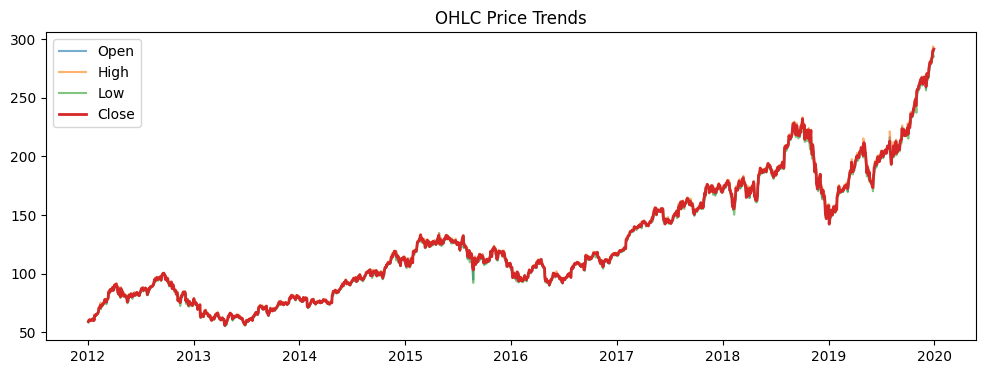

In [12]:
#OHLC Price Trend
plt.figure(figsize=(12,4))
plt.plot(df['Open'], label='Open', alpha=0.6)
plt.plot(df['High'], label='High', alpha=0.6)
plt.plot(df['Low'], label='Low', alpha=0.6)
plt.plot(df['Close'], label='Close', linewidth=2)
plt.title("OHLC Price Trends")
plt.legend()
plt.show()

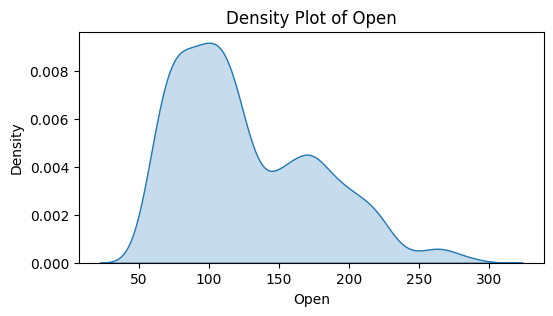

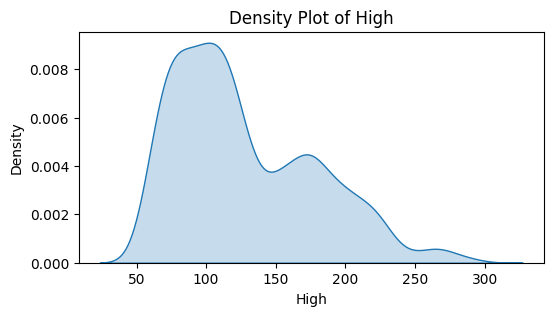

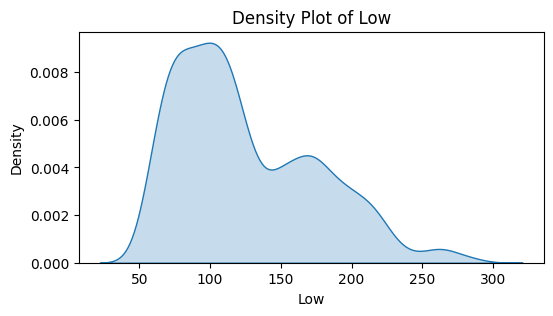

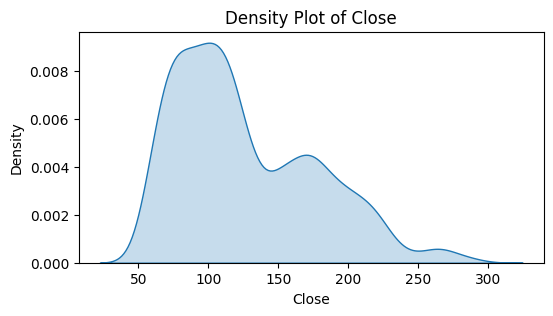

In [13]:
#Density Plots (Distribution)
price_cols = ['Open','High','Low','Close']

for col in price_cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df[col], fill=True)
    plt.title(f"Density Plot of {col}")
    plt.show()

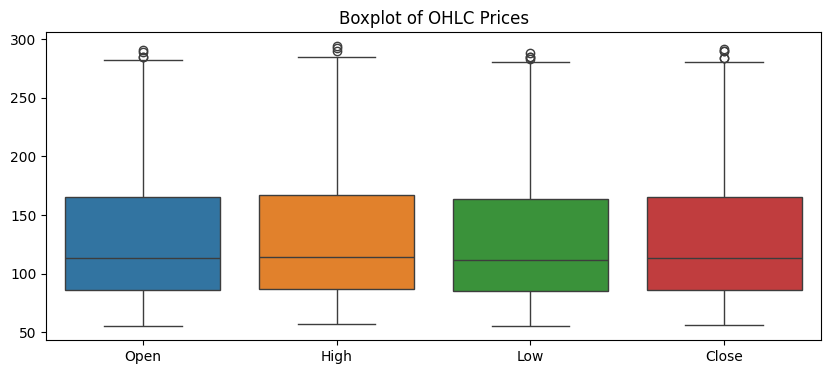

In [14]:
#Boxplot for Outlier Detection
plt.figure(figsize=(10,4))
sns.boxplot(data=df[['Open','High','Low','Close']])
plt.title("Boxplot of OHLC Prices")
plt.show()

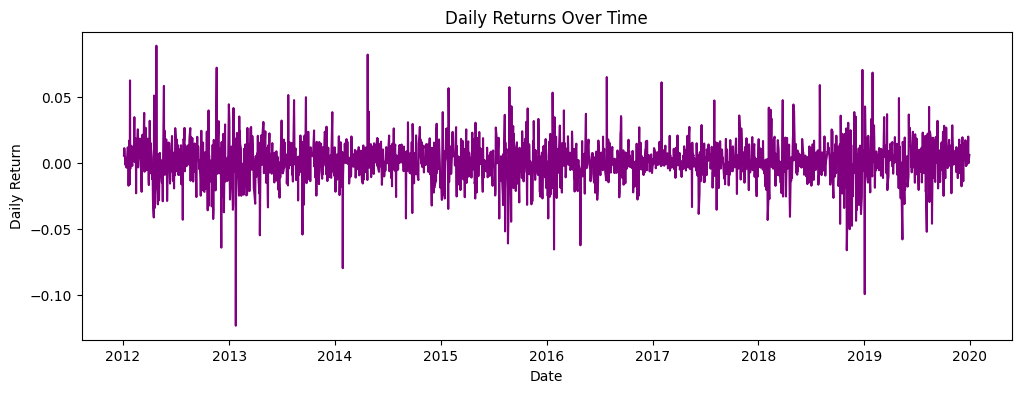

In [15]:
#Daily Returns Time Series
plt.figure(figsize=(12,4))
plt.plot(df['Daily_Return'], color='purple')
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()

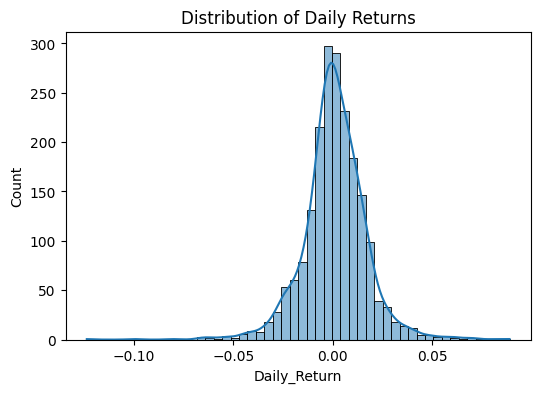

In [16]:
#Daily Returns Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Daily_Return'], bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

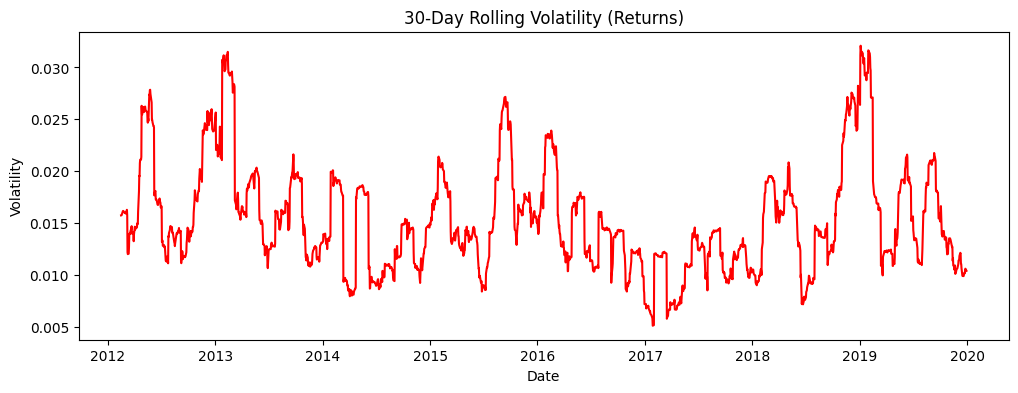

In [17]:
#Rolling Volatility using Returns
df['Return_Volatility_30'] = df['Daily_Return'].rolling(30).std()

plt.figure(figsize=(12,4))
plt.plot(df['Return_Volatility_30'], color='red')
plt.title("30-Day Rolling Volatility (Returns)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

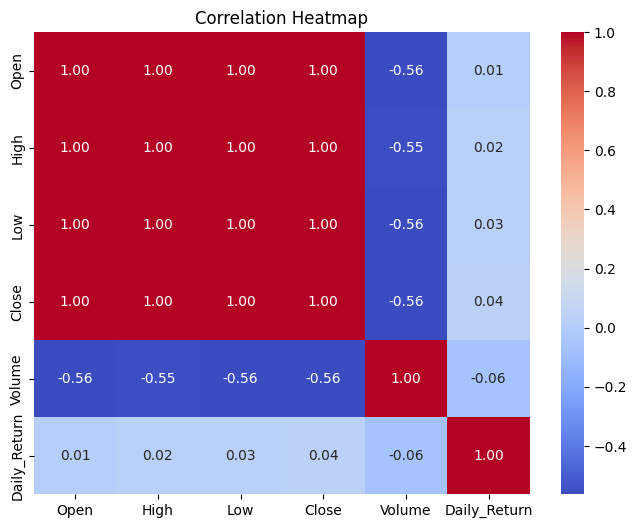

In [18]:
#Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df[['Open','High','Low','Close','Volume','Daily_Return']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

##### Key Insights:

OHLC prices → highly correlated

Daily returns → low correlation (stationary behavior)

In [19]:
# First-order differencing to remove trend
df['Close_Diff'] = df['Close'] - df['Close'].shift(1)

# Remove NaN created after differencing
df.dropna(inplace=True)

<Figure size 1000x400 with 0 Axes>

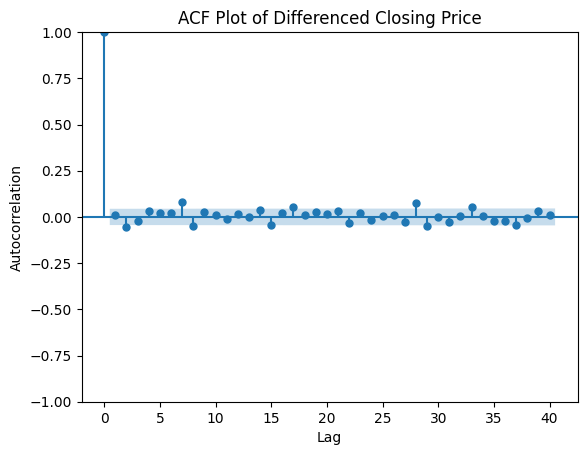

In [20]:
#### ACF Plot
plt.figure(figsize=(10,4))

# ACF plot helps identify MA (q) component
plot_acf(df['Close_Diff'],lags=40,alpha=0.05)

plt.title("ACF Plot of Differenced Closing Price")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

<Figure size 1000x400 with 0 Axes>

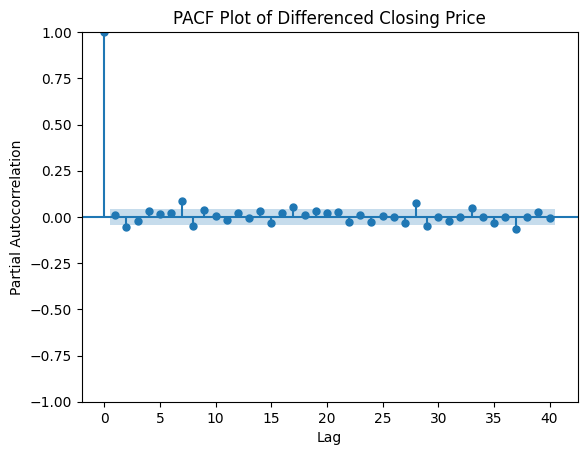

In [21]:
#### PACF Plot
plt.figure(figsize=(10,4))

# PACF plot helps identify AR (p) component
plot_pacf(df['Close_Diff'],lags=40,alpha=0.05,method='ywm')

plt.title("PACF Plot of Differenced Closing Price")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.show()

#### FEATURE ENGINEERING (FOR ML MODELS)

In [22]:
# Outlier Capping for Ml models
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

df['Close_Capped'] = df['Close'].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

In [23]:
# Create ML features

# Moving averages
df['MA_10'] = df['Close_Capped'].rolling(10).mean()
df['MA_30'] = df['Close_Capped'].rolling(30).mean()

# Volatility measure
df['Volatility'] = df['Close_Capped'].rolling(30).std()

# Lag feature
df['Lag_1'] = df['Close_Capped'].shift(1)

# Drop rows with NaN values
df.dropna(inplace=True)

#### TRAIN–TEST SPLIT

In [24]:
# Ensure business-day frequency
df = df.asfreq('B')
df = df.fillna(method='ffill')

In [25]:
#Splitting the data explicitly
# Last 30 days used as test set
train = df.iloc[:-30]
test = df.iloc[-30:]

#Splitting the data for Statistics Models
y_train = train['Close']
y_test = test['Close']

#Splitting the data for ML models
features = ['MA_10','MA_30','Volatility','Lag_1']
y_train_ml = train['Close_Capped']
y_test_ml = test['Close_Capped']
X_train = train[features]
X_test = test[features]

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train_ml.shape)
print(y_test_ml.shape)

(1994, 4)
(30, 4)
(1994,)
(30,)
(1994,)
(30,)


#### NORMALIZATION

In [27]:
#Normalization (only for ML Models)
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### STATISTICAL MODELS
#### ARIMA

In [28]:
# Train ARIMA
arima = ARIMA(y_train, order=(5,1,1))
arima_fit = arima.fit()

# Forecast next 30 business days
arima_forecast = arima_fit.forecast(30)

In [29]:
arima_forecast

2019-11-19    266.935040
2019-11-20    267.000752
2019-11-21    266.818278
2019-11-22    267.254430
2019-11-25    267.044659
2019-11-26    267.179460
2019-11-27    267.066224
2019-11-28    267.151601
2019-11-29    267.116976
2019-12-02    267.131121
2019-12-03    267.125833
2019-12-04    267.123801
2019-12-05    267.130968
2019-12-06    267.123538
2019-12-09    267.129871
2019-12-10    267.124630
2019-12-11    267.128648
2019-12-12    267.125966
2019-12-13    267.127605
2019-12-16    267.126683
2019-12-17    267.127107
2019-12-18    267.127009
2019-12-19    267.126933
2019-12-20    267.127083
2019-12-23    267.126915
2019-12-24    267.127069
2019-12-25    267.126944
2019-12-26    267.127037
2019-12-27    267.126974
2019-12-30    267.127013
Freq: B, Name: predicted_mean, dtype: float64

#### SARIMA

In [30]:
# Train SARIMA
sarima = SARIMAX(y_train,order=(5,1,1),seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit()

# Forecast next 30 business days
sarima_forecast = sarima_fit.forecast(30)

In [31]:
sarima_forecast

2019-11-19    267.058248
2019-11-20    267.176977
2019-11-21    267.173558
2019-11-22    267.935453
2019-11-25    267.815844
2019-11-26    268.059968
2019-11-27    268.013273
2019-11-28    268.186540
2019-11-29    268.066399
2019-12-02    268.081920
2019-12-03    268.045268
2019-12-04    268.065187
2019-12-05    268.251980
2019-12-06    268.309433
2019-12-09    268.502767
2019-12-10    268.817440
2019-12-11    268.924880
2019-12-12    269.039216
2019-12-13    269.117901
2019-12-16    269.207220
2019-12-17    269.135074
2019-12-18    269.127709
2019-12-19    269.114825
2019-12-20    269.147839
2019-12-23    269.324528
2019-12-24    269.390568
2019-12-25    269.575950
2019-12-26    269.898897
2019-12-27    270.000946
2019-12-30    270.118601
Freq: B, Name: predicted_mean, dtype: float64

### MACHINE LEARNING MODELS (WITH GRID SEARCH)

#### Random Forest

In [32]:
#time series split
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    {'n_estimators':[50,100],'max_depth':[3,5,None]},
    cv=tscv,
    scoring='neg_mean_squared_error'
)

rf_grid.fit(X_train_scaled,y_train_ml)
rf_forecast = rf_grid.best_estimator_.predict(X_test_scaled)

In [33]:
rf_forecast

array([264.34780836, 264.00200756, 263.59660782, 263.61220778,
       263.61220778, 263.83460736, 260.75740582, 260.75740582,
       260.71640542, 260.83160562, 260.49240646, 259.59120528,
       260.4380058 , 260.71940562, 260.71940562, 260.71940562,
       260.71940562, 260.71940562, 260.71940562, 260.71940562,
       260.71940562, 260.71940562, 260.71940562, 260.71940562,
       260.71940562, 260.71940562, 260.71940562, 260.82780558,
       260.82940562, 260.83160562])

#### XGBoost

In [34]:
# XGBoost
xgb_grid = GridSearchCV(
    XGBRegressor(random_state=42),
    {'n_estimators':[50,100],'learning_rate':[0.05,0.1],'max_depth':[3,5],'subsample': [0.8, 1.0]},
    cv=tscv,
    scoring='neg_mean_squared_error'
)

xgb_grid.fit(X_train_scaled,y_train_ml)
xgb_forecast = xgb_grid.best_estimator_.predict(X_test_scaled)

In [35]:
xgb_forecast

array([260.43414, 260.43414, 260.43414, 260.43414, 260.43414, 252.47473,
       250.75017, 250.75017, 246.75356, 248.75359, 248.63744, 249.55162,
       249.42548, 249.42548, 248.95967, 248.6365 , 247.18436, 247.55045,
       246.54834, 247.55045, 246.61176, 247.18436, 247.18436, 246.75876,
       248.95967, 249.42548, 249.42548, 249.11928, 249.7014 , 249.7014 ],
      dtype=float32)

### MODEL COMPARISON & VISUALIZATION

#### Model Evaluation

In [36]:
#function for evaluating the model performance
def evaluate(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Random Forest", "XGBoost"],
    "MAE": [evaluate(y_test, arima_forecast)[0],
            evaluate(y_test, sarima_forecast)[0],
            evaluate(y_test_ml, rf_forecast)[0],
            evaluate(y_test_ml, xgb_forecast)[0]],
    "RMSE": [evaluate(y_test, arima_forecast)[1],
             evaluate(y_test, sarima_forecast)[1],
             evaluate(y_test_ml, rf_forecast)[1],
             evaluate(y_test_ml, xgb_forecast)[1]]
    })

In [38]:
results

,Model,MAE,RMSE
0,ARIMA,8.115737,10.961011
1,SARIMA,7.265237,9.608715
2,Random Forest,11.387867,14.336083
3,XGBoost,21.701512,24.543808


#### Model Visualization

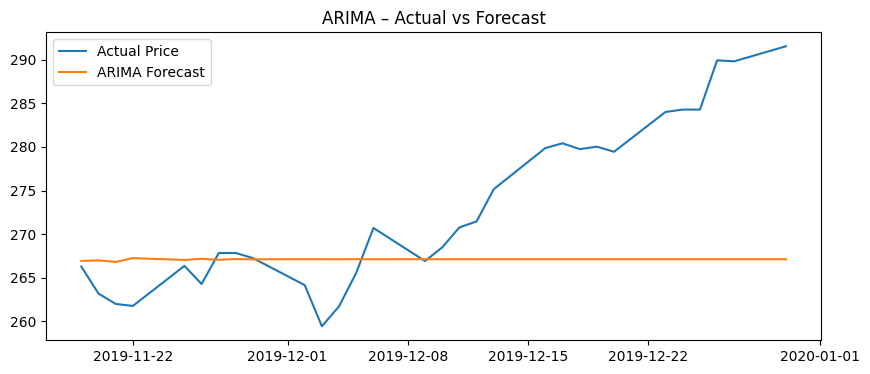

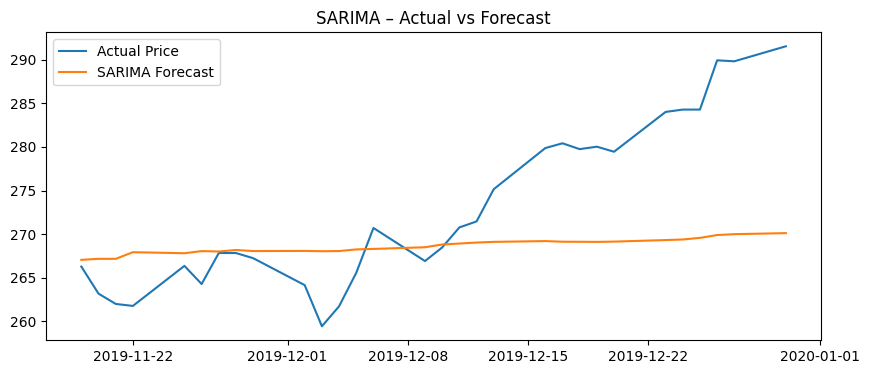

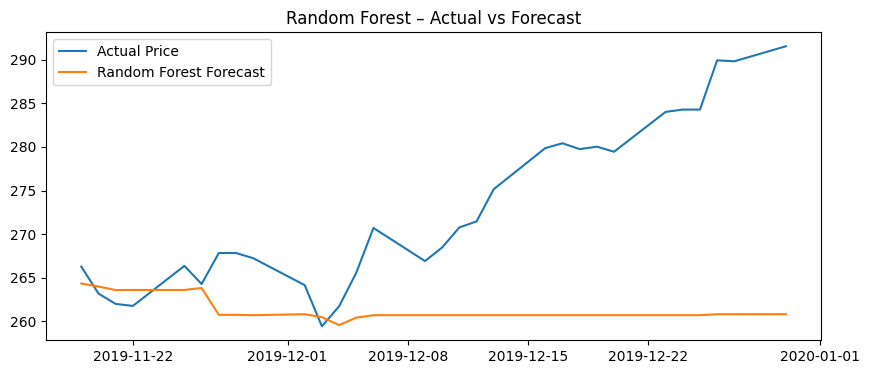

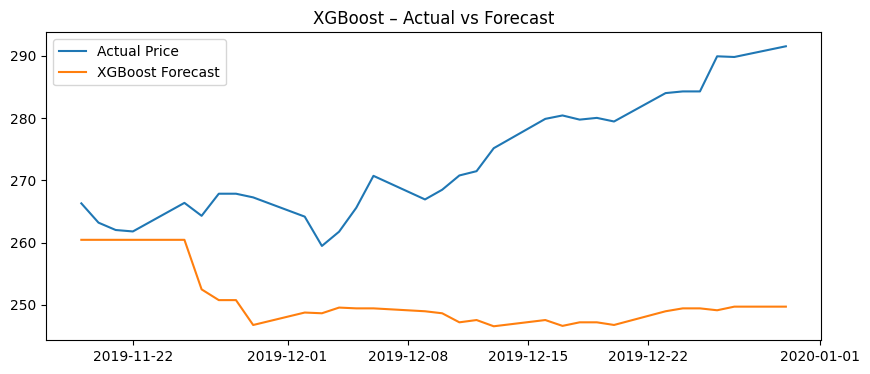

In [39]:
models = {
    "ARIMA": arima_forecast,
    "SARIMA": sarima_forecast,
    "Random Forest": rf_forecast,
    "XGBoost": xgb_forecast
}

for name, pred in models.items():
    plt.figure(figsize=(10,4))
    plt.plot(test.index, y_test, label="Actual Price")
    plt.plot(test.index, pred, label=f"{name} Forecast")
    plt.title(f"{name} – Actual vs Forecast")
    plt.legend()
    plt.show()

#### Forecast Visualization together

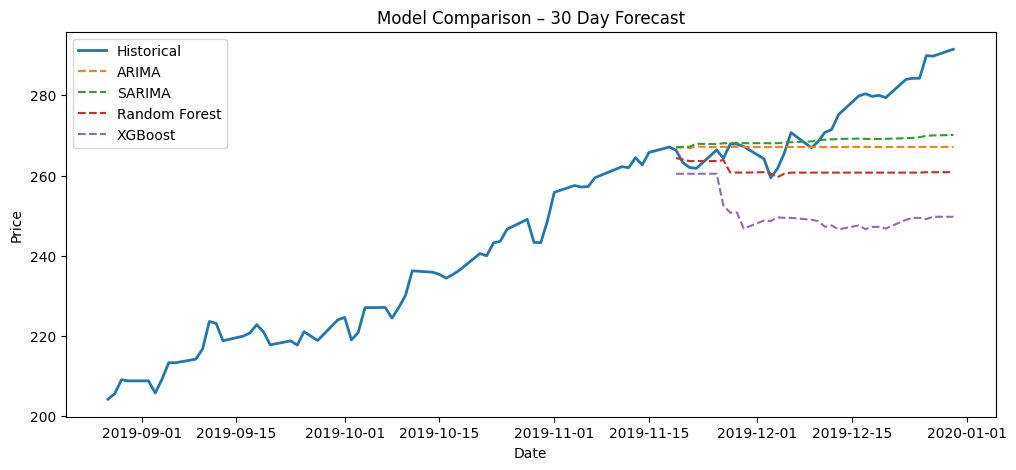

In [40]:
plt.figure(figsize=(12,5))

plt.plot(df['Close'].tail(90), label="Historical", linewidth=2)
plt.plot(test.index, arima_forecast, '--', label="ARIMA")
plt.plot(test.index, sarima_forecast, '--', label="SARIMA")
plt.plot(test.index, rf_forecast, '--', label="Random Forest")
plt.plot(test.index, xgb_forecast, '--', label="XGBoost")

plt.title("Model Comparison – 30 Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [41]:
print("Best Model Selected: SARIMA")

Best Model Selected: SARIMA


In [43]:
with open("sarima_model.pkl", "wb") as file:
    pickle.dump(sarima_fit, file)

print("SARIMA model saved successfully!")

SARIMA model saved successfully!


#### Conclusion:
- Among all evaluated models, SARIMA was selected as the final forecasting model due to its ability to simultaneously capture trend, seasonality, and temporal dependencies in stock prices. 
- The model demonstrated superior predictive performance in terms of both error metrics and forecast stability, making it well-suited for short-term stock price forecasting.
- SARIMA was selected because it effectively captures both trend and seasonal patterns in stock prices and provides stable, interpretable, and accurate forecasts.